In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import load_wine

In [3]:
wine_data = load_wine()

In [4]:
df = pd.DataFrame(data=wine_data.data,columns=wine_data.feature_names)

In [5]:
df['target'] = wine_data.target

In [6]:
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [7]:
df['target'].value_counts().sort_index()

,count
target,
0,59
1,71
2,48


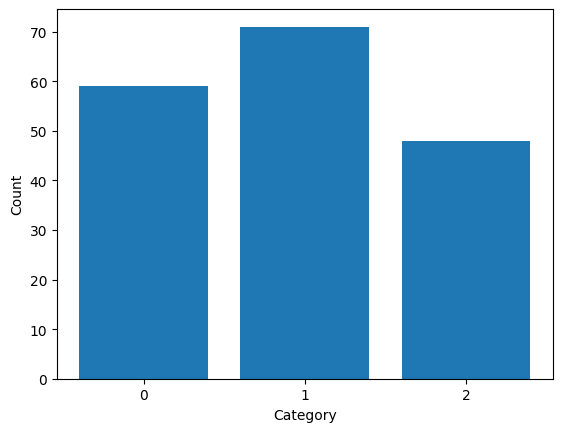

In [8]:
fig,ax = plt.subplots()
ax.bar(df['target'].unique(),df['target'].value_counts().sort_index())
ax.set_xlabel('Category')
ax.set_ylabel('Count')
ax.set_xticks(df['target'].unique())

In [9]:
from sklearn.model_selection import train_test_split

X = df.drop(['target'],axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,shuffle=True,stratify=y,random_state=42)

In [10]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score

In [11]:
gbc = GradientBoostingClassifier(max_depth=5,random_state=42)
gbc.fit(X_train,y_train)
y_pred = gbc.predict(X_test)
f1_score(y_test,y_pred,average='weighted')

0.9077681577681579

# Filter metode

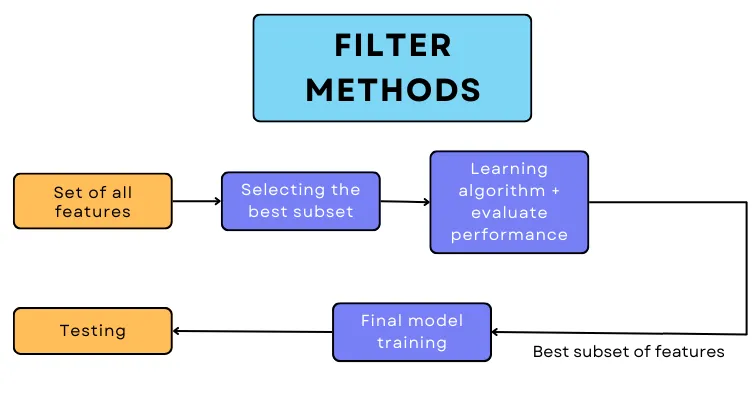

## VarianceThreshold

Ukoliko je varijansa nekog atributa 0, tada je taj atribut konstantan. Atributi koji imaju varijansu 0 nisu prediktivni, samim tim, mogu se eliminisati iz skupa atributa.

In [12]:
X_train1, X_test1, y_train1, y_test1 = X_train.copy(),X_test.copy(),y_train.copy(),y_test.copy()

In [13]:
X_train1.var(axis=0)

,0
alcohol,0.658341
malic_acid,1.123507
ash,0.072433
alcalinity_of_ash,11.471279
magnesium,232.071532
total_phenols,0.393226
flavanoids,0.912299
nonflavanoid_phenols,0.013873
proanthocyanins,0.335108
color_intensity,5.669722


In [14]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train1)
X_test_scaled = scaler.transform(X_test1)

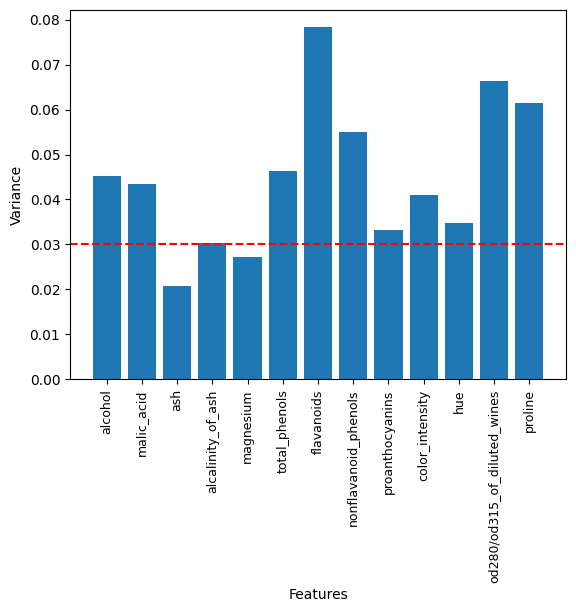

In [15]:
plt.bar(x=wine_data.feature_names, height=X_train_scaled.var(axis=0))
plt.axhline(y=0.03, color='r', linestyle='--', label='Threshold = 0.03')
plt.xlabel("Features")
plt.ylabel("Variance")
plt.xticks(rotation=90,fontsize=9)
plt.show()

In [16]:
selected_X_train1 = X_train1.drop(['ash','magnesium'],axis=1)

In [17]:
selected_X_test1 = X_test1.drop(['ash','magnesium'],axis=1)

In [18]:
gbc.fit(selected_X_train1,y_train)

GradientBoostingClassifier(max_depth=5, random_state=42)

In [19]:
y_pred_var = gbc.predict(selected_X_test1)

In [20]:
f1_score_var = f1_score(y_pred_var,y_test,average='weighted')
f1_score_var

0.9627050471878059

###VarianceThreshold u Scikit-learnu

In [21]:
# from sklearn.feature_selection import VarianceThreshold
# vt = VarianceThreshold(threshold=0.03)
# X_vt = vt.fit_transform(X_train_scaled)
# selected_attributes = columns[vt.get_support()]
# print(selected_attributes)

##K-Best

Koristi metriku značajnosti atributa i na osnovu nje bira K najboljih.

U zavisnosti od tipa atributa i ciljne promenljive, mogu se koristiti razlicite metrike znacajnosti:

- Atributi numericki:
    - Ciljna promenljiva kategoricka: t-test
    - Ciljna promenljiva numericka: Pearson correlation, Spearman's rank correlation
- Atributi kategoricki:
    - Ciljna promenljiva kategoricka: Chi squared
    - Ciljna promenljiva numericka: t-test

U svim slucajevima se moze koristiti i Mutual information

In [22]:
X_train_v2, X_test_v2, y_train_v2, y_test_v2 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

In [23]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

In [24]:
f1_score_list = []

for k in range(1, 14):
    selector = SelectKBest(mutual_info_classif, k=k)
    selector.fit(X_train_v2, y_train_v2)

    sel_X_train_v2 = selector.transform(X_train_v2)
    sel_X_test_v2 = selector.transform(X_test_v2)

    gbc.fit(sel_X_train_v2, y_train_v2)
    kbest_preds = gbc.predict(sel_X_test_v2)

    f1_score_kbest = round(f1_score(y_test_v2, kbest_preds, average='weighted'), 3)

    f1_score_list.append(f1_score_kbest)

In [25]:
max(f1_score_list)

0.981

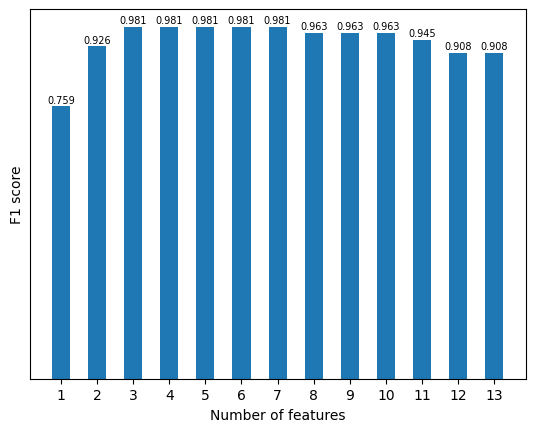

In [26]:
plt.bar(x=range(1,len(f1_score_list)+1), height=f1_score_list,width=0.5)
plt.xticks(range(1,len(f1_score_list)+1))
plt.yticks([])
plt.xlabel("Number of features")
plt.ylabel("F1 score")

for i, value in enumerate(f1_score_list, start=1):
    plt.text(x=i, y=value + 0.01, s=f"{value:.3f}", ha='center', fontsize=7)

plt.show()

In [27]:
selector = SelectKBest(mutual_info_classif, k=3)
selector.fit(X_train_v2, y_train_v2)

selected_feature_mask = selector.get_support()
selected_features = X_train_v2.columns[selected_feature_mask]

selected_features

Index(['flavanoids', 'color_intensity', 'proline'], dtype='object')

Mana ovih metoda jeste što se interakcije između atributa i ciljne promenljive gledaju nezavisno, bez razmatranja međusobnih interakcija više atributa.

## Correlation matrix

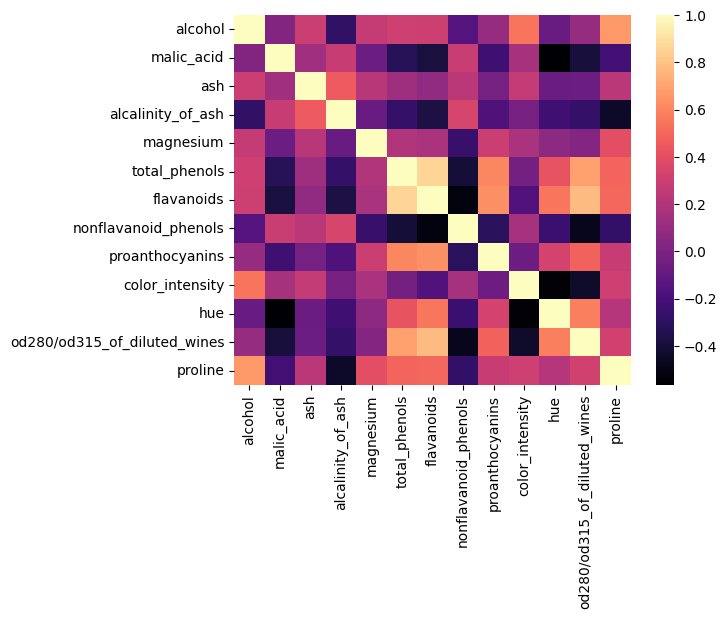

In [33]:
import seaborn as sns
corr_mat=X_train_v2.corr()
sns.heatmap(corr_mat, cmap='magma');

Mogu se eliminisati atributi koji su visokokorelisani, npr. hue i malic_acid, dubljom analizom moze se jedan od njih eliminisati.

# Wrapper metode

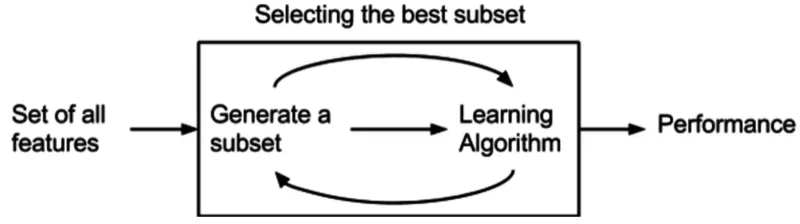

#Recursive feature elimination (RFE)

In [28]:
X_train_v3, X_test_v3, y_train_v3, y_test_v3 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

In [29]:
from sklearn.feature_selection import RFE

rfe_f1_score_list = []

for k in range(1, 14):
    RFE_selector = RFE(estimator=gbc, n_features_to_select=k, step=1)
    RFE_selector.fit(X_train_v3, y_train_v3)

    sel_X_train_v3 = RFE_selector.transform(X_train_v3)
    sel_X_test_v3 = RFE_selector.transform(X_test_v3)

    gbc.fit(sel_X_train_v3, y_train_v3)
    RFE_preds = gbc.predict(sel_X_test_v3)

    f1_score_rfe = round(f1_score(y_test_v3, RFE_preds, average='weighted'), 3)

    rfe_f1_score_list.append(f1_score_rfe)

In [31]:
rfe_f1_score_list

[0.622,
 0.85,
 1.0,
 0.981,
 0.963,
 0.963,
 0.869,
 0.908,
 0.908,
 0.908,
 0.908,
 0.908,
 0.908]

In [30]:
RFE_selector = RFE(estimator=gbc, n_features_to_select=3, step=10)
RFE_selector.fit(X_train_v3, y_train_v3)

selected_features_mask = RFE_selector.get_support()

selected_features = X_train_v3.columns[selected_features_mask]
selected_features

Index(['color_intensity', 'od280/od315_of_diluted_wines', 'proline'], dtype='object')

In [ ]:
#rfe = RFECV(estimator=gbc) RFE koji sam odredjuje najbolji broj atributa

- https://scikit-learn.org/dev/modules/generated/sklearn.feature_selection.RFE.html
- https://machinelearningmastery.com/rfe-feature-selection-in-python/

#Embedded metode

Metode koje prilikom treniranja modela ujedno i računaju značajnost svakog atributa. Primeri:
- Regularizacija u linearnog regresiji: Lasso, Ridge, ElasticNet
- Logistička regresija sa regularizacijom
- Tree-based modeli koji prilikom treniranja računaju značajnost atibuta na osnovu Ginijevog indeksa, Entropije ...

Jos neke od *Feature selection* metoda na konkretnim primerima mogu se pogledati na [linku](https://github.com/codingnest/FeatureSelection/blob/master/Data%20Science%20Lifecycle%20-%20Feature%20Selection%20(Filter%2C%20Wrapper%2C%20Embedded%20and%20Hybrid%20Methods).ipynb)